# Haldane model

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

Nx = 6  # number of unit cells along a1
Ny = 6  # number of unit cells along a2
N_cells = Nx * Ny
dim = 2 * N_cells  # two sites per unit cell

t1 = 2.0      # nearest-neighbor hopping amplitude
t2 = 0.5      # next-nearest-neighbor hopping amplitude
phi = np.pi/2  # phase for NNN hopping
M = 1     # on-site staggered potential (A: +M, B: -M)

# Tolerance for determining connectivity
tol = 0.10

# Bravais lattice vectors
a1 = np.array([np.sqrt(3)/2, 3/2])
a2 = np.array([-np.sqrt(3)/2, 3/2])

# Basis positions within the unit cell:
r_A_basis = np.array([0, 0])
r_B_basis = np.array([0, 1])

positions = {}      # dictionary: site index -> (x, y)
sublattice = {}     # dictionary: site index -> 'A' or 'B'
cell_index = 0

for i in range(Nx):
    for j in range(Ny):
        # Compute Bravais lattice vector for this unit cell
        R = i * a1 + j * a2
        # Position for A site in cell (i,j)
        idx_A = 2 * cell_index
        pos_A = R + r_A_basis
        positions[idx_A] = pos_A
        sublattice[idx_A] = 'A'
        # Position for B site in cell (i,j)
        idx_B = 2 * cell_index + 1
        pos_B = R + r_B_basis
        positions[idx_B] = pos_B
        sublattice[idx_B] = 'B'
        cell_index += 1

# cell index = i Ny + j hence i = cell_index // Ny  and j = cell_index mod Ny



H = np.zeros((dim, dim), dtype=complex)

# on-site potentials:
for i in range(dim):
    if sublattice[i] == 'A':
        H[i, i] += M
    else:
        H[i, i] += -M

# Pre-calculate distances expected for NN and NNN:
NN_distance = 1.0
NNN_distance = np.sqrt(3)

# Loop over all pairs of sites i<j to add hopping terms.
for i in range(dim):
    for j in range(i+1, dim):
        rij = positions[i] - positions[j]
        dist = np.linalg.norm(rij)

        # Nearest-neighbor (NN) hopping
        if abs(dist - NN_distance) < tol:
            H[i, j] += -t1
            H[j, i] += -t1  # Hermitian conjugate

        # Next-nearest-neighbor (NNN) hopping with complex phase
        elif abs(dist - NNN_distance) < tol and (sublattice[i] == sublattice[j]):
            # Find the common nearest neighbor
            common_neighbors = []
            for k in range(dim):
                if k == i or k == j:
                    continue
                if (abs(np.linalg.norm(positions[i] - positions[k]) - NN_distance) < tol and
                    abs(np.linalg.norm(positions[j] - positions[k]) - NN_distance) < tol):
                    common_neighbors.append(k)

            if len(common_neighbors) == 1:
                k = common_neighbors[0]
                v1 = positions[k] - positions[i]
                v2 = positions[j] - positions[k]
                cross_z = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product in 2D
                nu_ij = 1 if cross_z > 0 else -1  # Assign chirality

                # Apply phase factor based on chirality
                H[i, j] += -t2 * np.exp(1j * nu_ij * phi)
                H[j, i] += -t2 * np.exp(-1j * nu_ij * phi)  # Hermitian conjugate

eigenvalues, eigenvectors = eigh(H)

# Get indices of eigenvalues closest to zero
nearest_indices = np.argsort(np.abs(eigenvalues))[:]
nearest_eigenvalues = eigenvalues[nearest_indices]
nearest_eigenvectors = eigenvectors[:, nearest_indices]

print("Eigenvalues closest to zero:", nearest_eigenvalues)

Eigenvalues closest to zero: [ 0.28750289 -0.28750289 -0.81914186  0.81914186 -1.31166332  1.31166332
  1.76410664 -1.76410664  1.86080061 -1.86080061 -2.12094991  2.12094991
 -2.13469101  2.13469101 -2.35335598  2.35335598  2.53075218 -2.53075218
  2.55952044 -2.55952044  2.64983076 -2.64983076 -2.84646486  2.84646486
 -2.98007434  2.98007434  2.99626896 -2.99626896 -3.11202286  3.11202286
  3.17499793 -3.17499793  3.26965741 -3.26965741  3.34277924 -3.34277924
 -3.34969038  3.34969038 -3.50062288  3.50062288 -3.54052064  3.54052064
  3.56630277 -3.56630277  3.73943426 -3.73943426 -3.7545918   3.7545918
 -3.92552806  3.92552806  4.03239269 -4.03239269  4.10584495 -4.10584495
 -4.2897014   4.2897014   4.47740232 -4.47740232  4.65849185 -4.65849185
  4.76674563 -4.76674563  4.86493607 -4.86493607  5.18927805 -5.18927805
 -5.32124953  5.32124953  5.51521548 -5.51521548 -5.80954145  5.80954145]


##  The honeycomb lattice structure

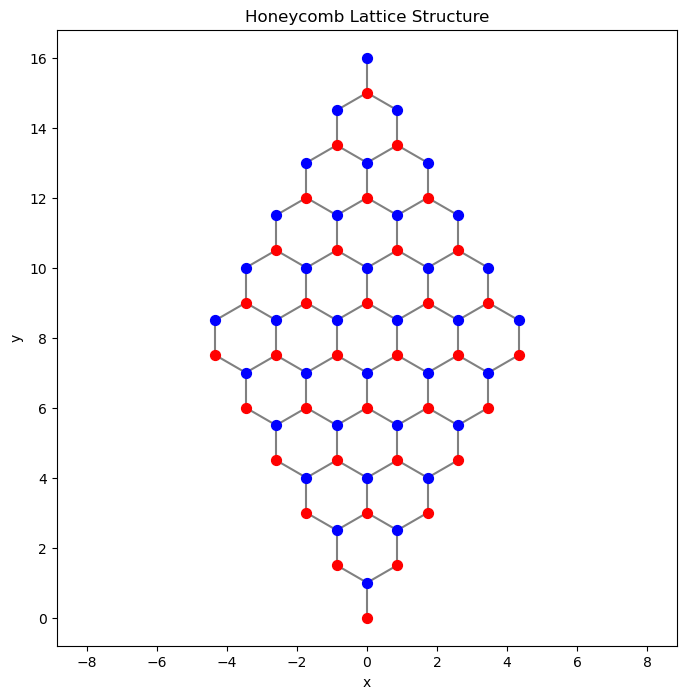

In [89]:
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Plot sites and label them by sublattice
for i in range(dim):
    x, y = positions[i]
    color = 'red' if sublattice[i]=='A' else 'blue'
    ax.scatter(x, y, color=color, s=50, zorder=3)

# Draw bonds for nearest-neighbor connections:
for i in range(dim):
    for j in range(i+1, dim):
        rij = positions[i] - positions[j]
        dist = np.linalg.norm(rij)
        if abs(dist - NN_distance) < tol:
            x_vals = [positions[i][0], positions[j][0]]
            y_vals = [positions[i][1], positions[j][1]]
            ax.plot(x_vals, y_vals, color='gray', zorder=1)

ax.set_title("Honeycomb Lattice Structure")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.axis('equal')
plt.show()

## Eigenvalue spectrum

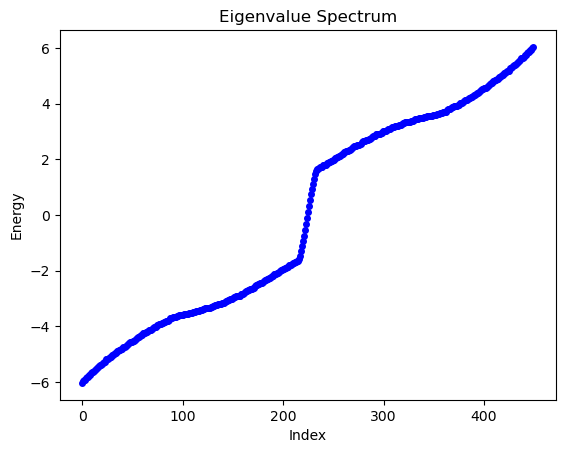

In [86]:
plt.figure()
plt.plot(eigenvalues, 'bo', markersize=4)
plt.title("Eigenvalue Spectrum")
plt.xlabel("Index")
plt.ylabel("Energy")
plt.show()

## Edge states

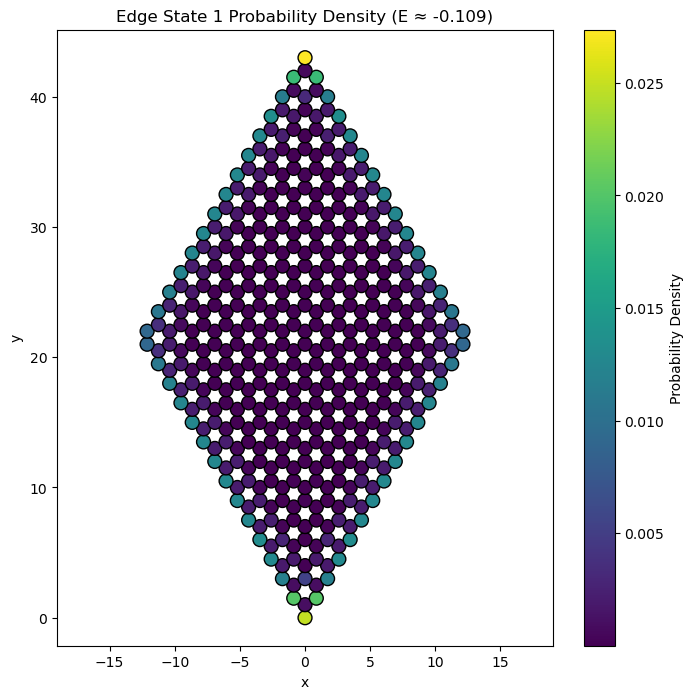

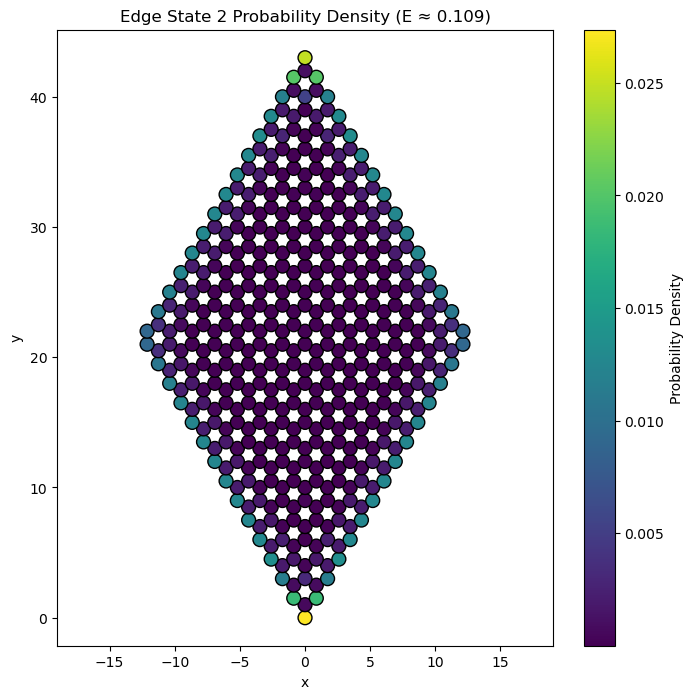

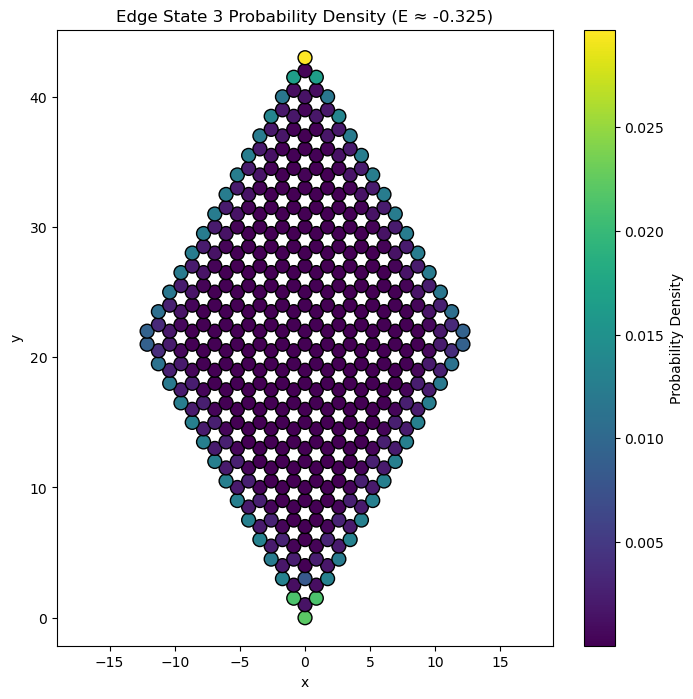

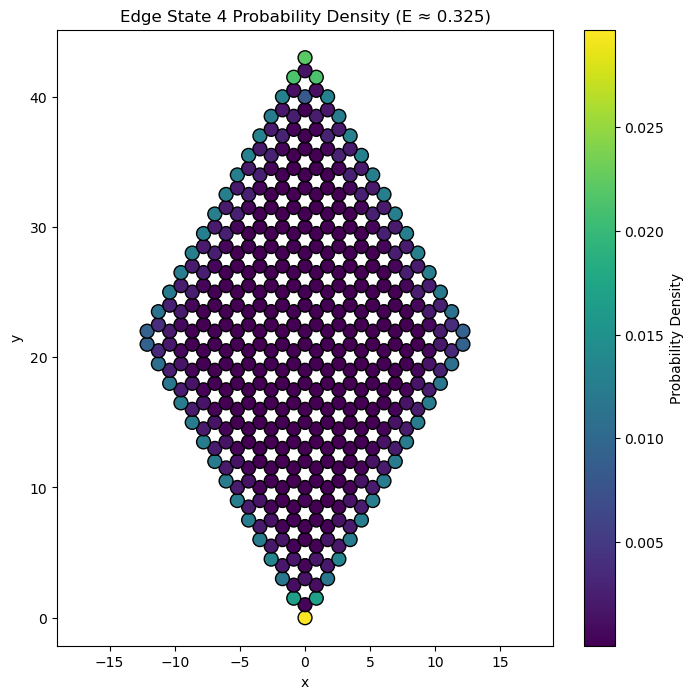

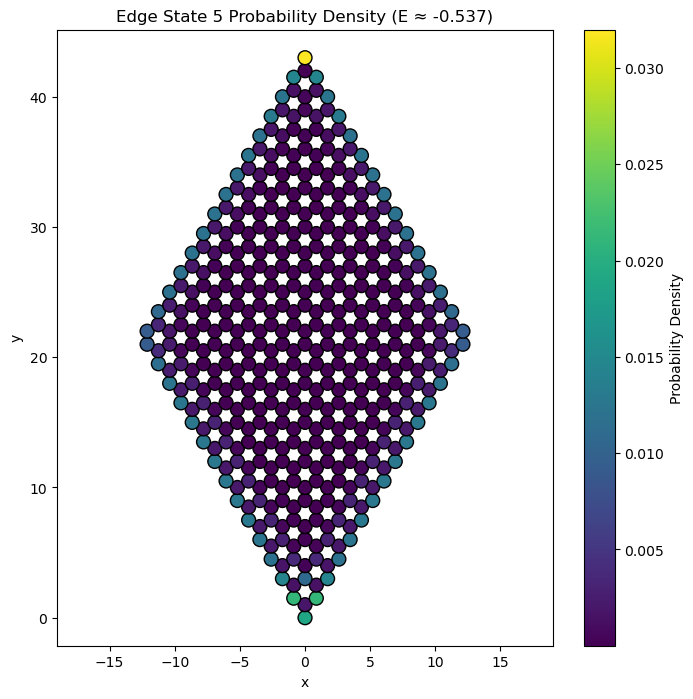

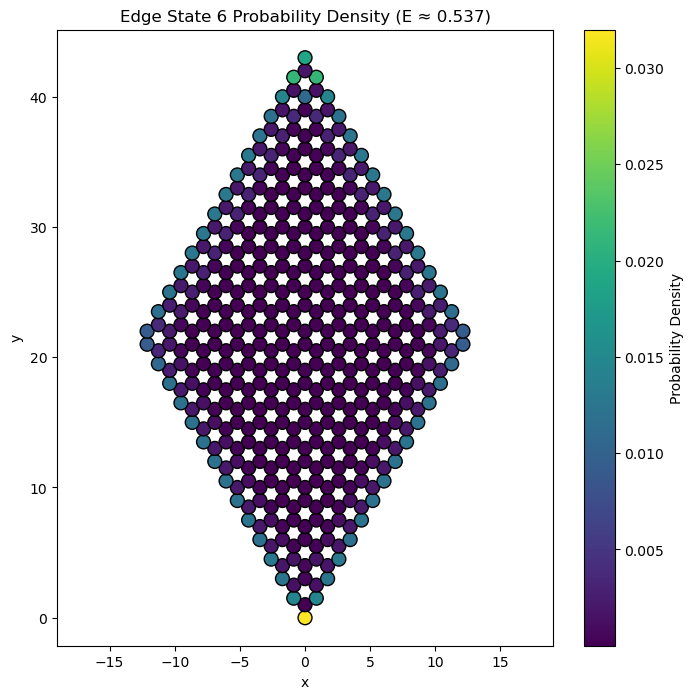

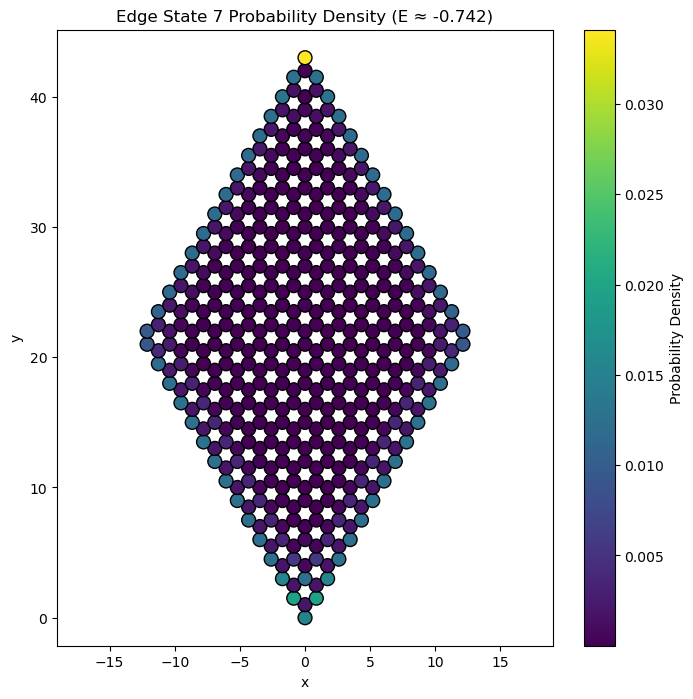

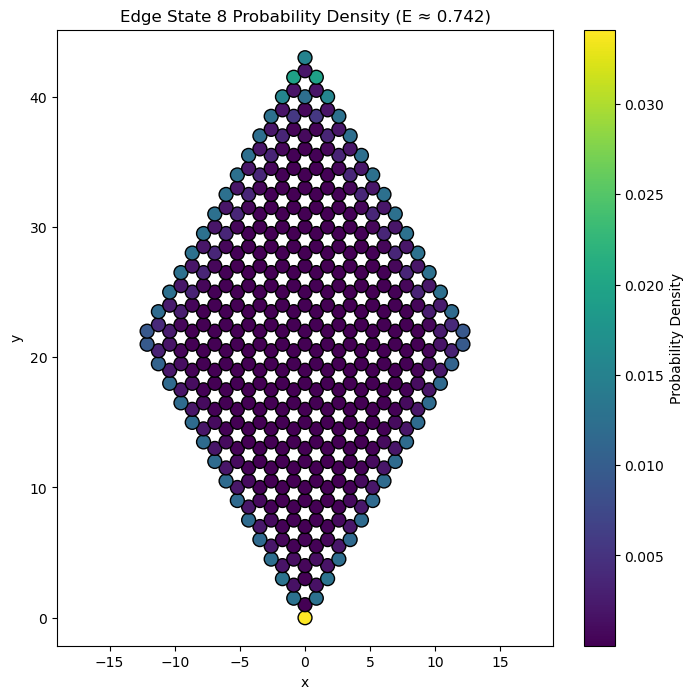

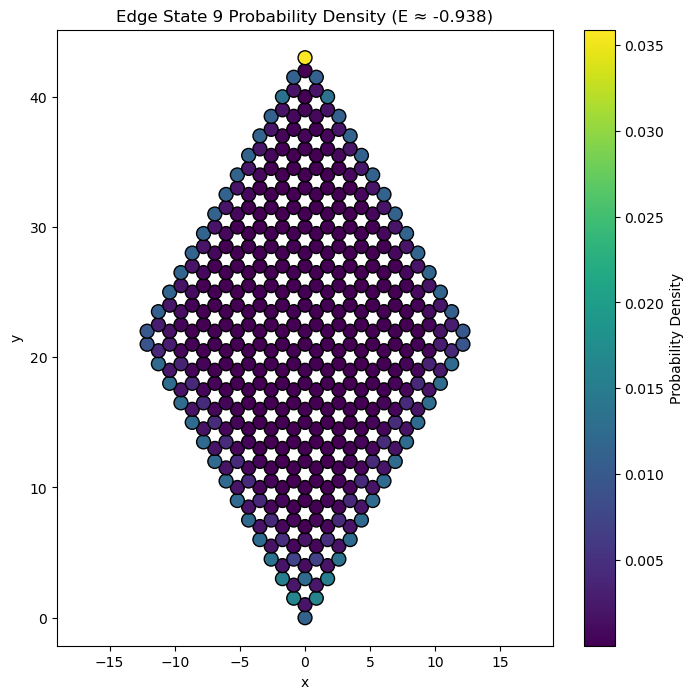

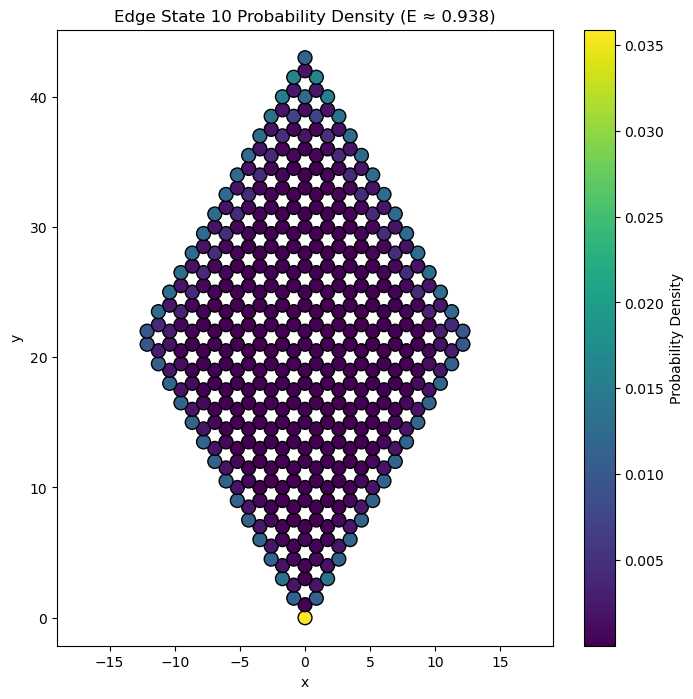

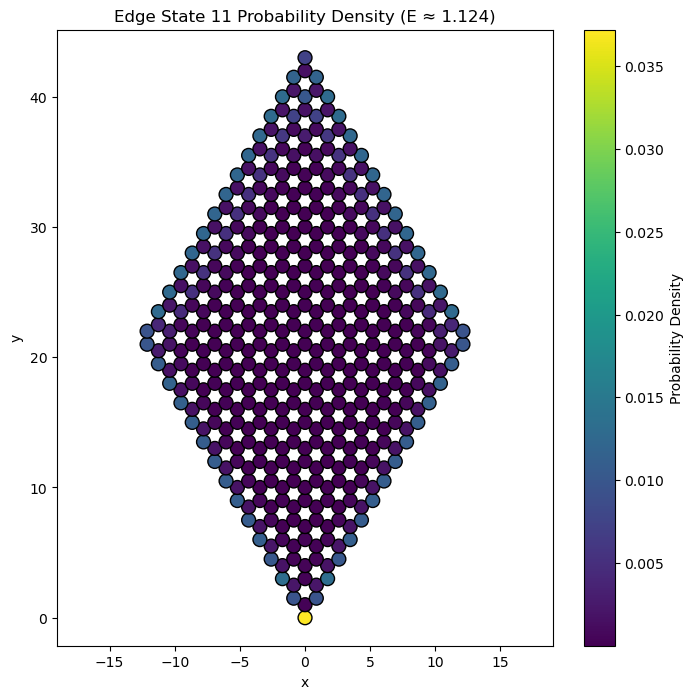

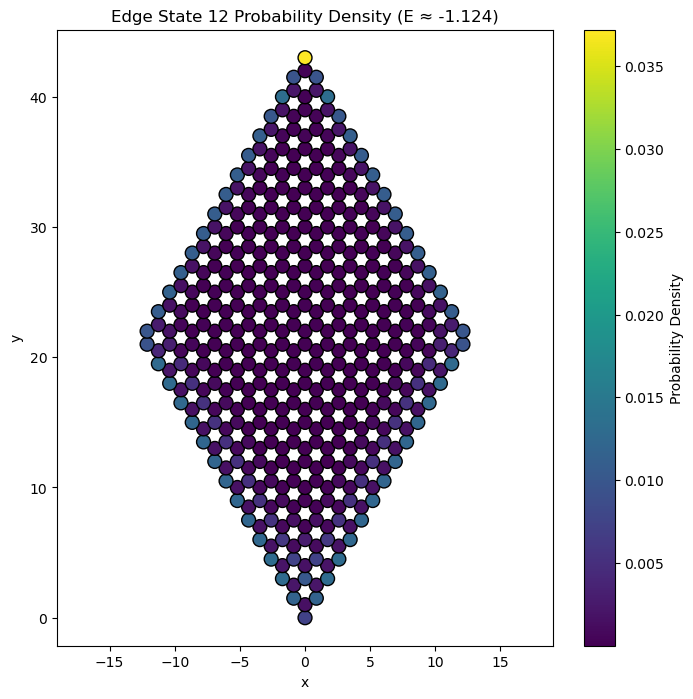

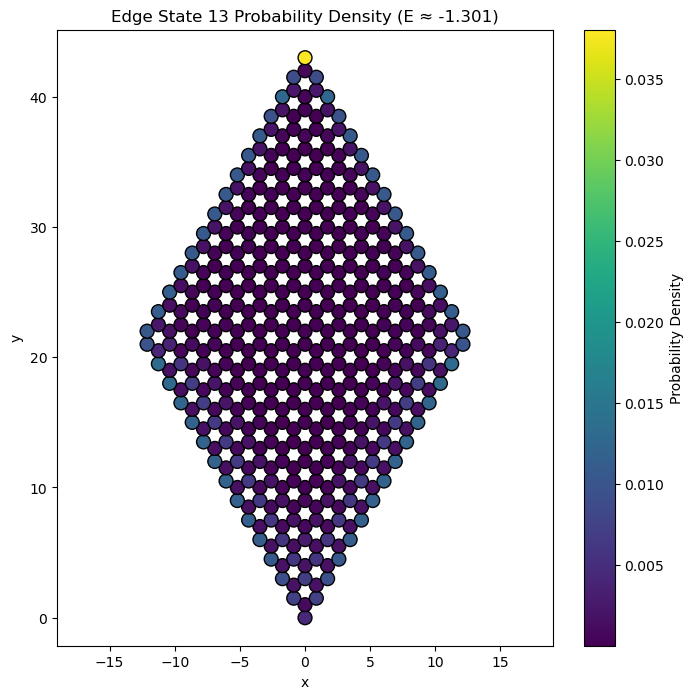

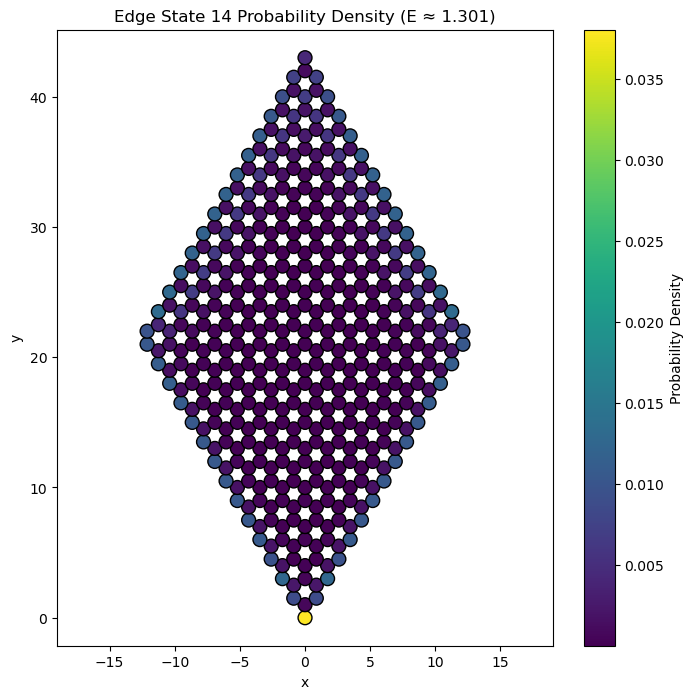

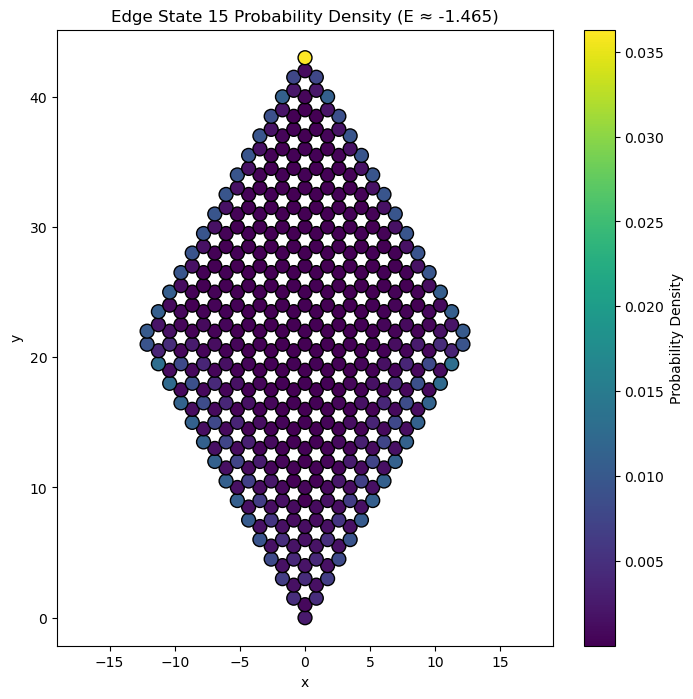

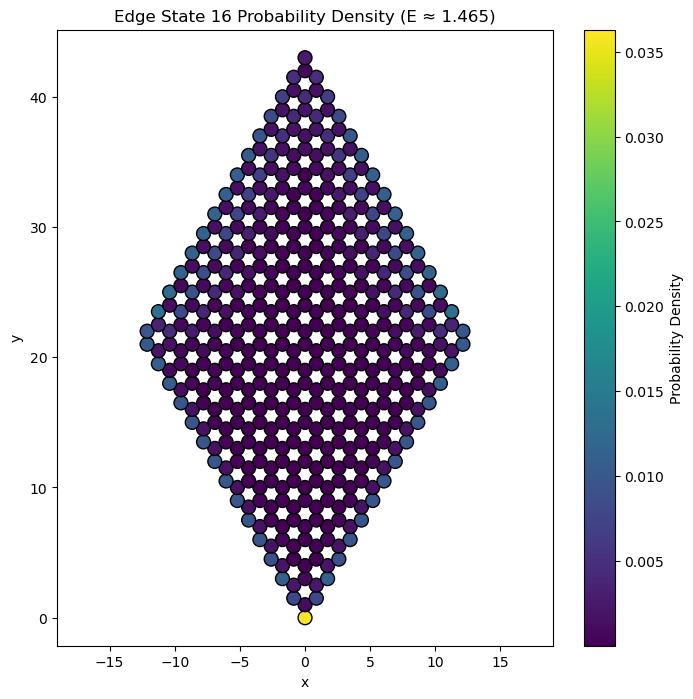

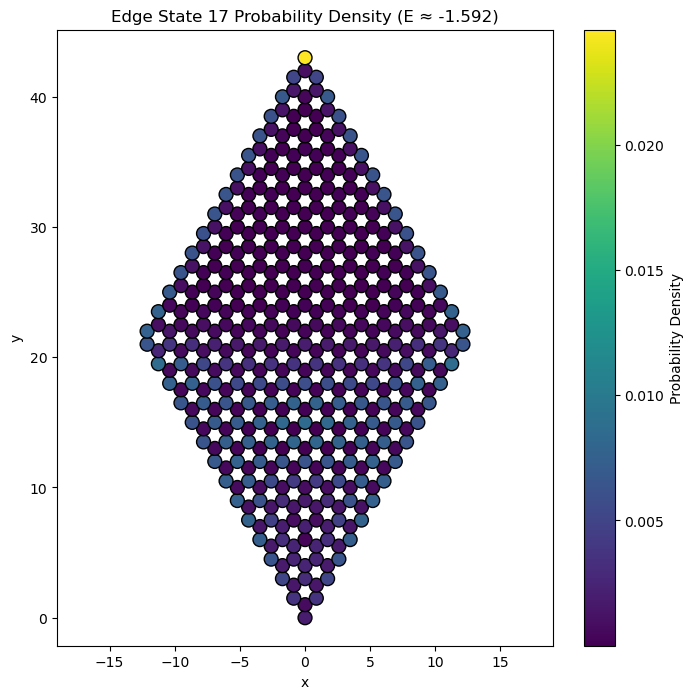

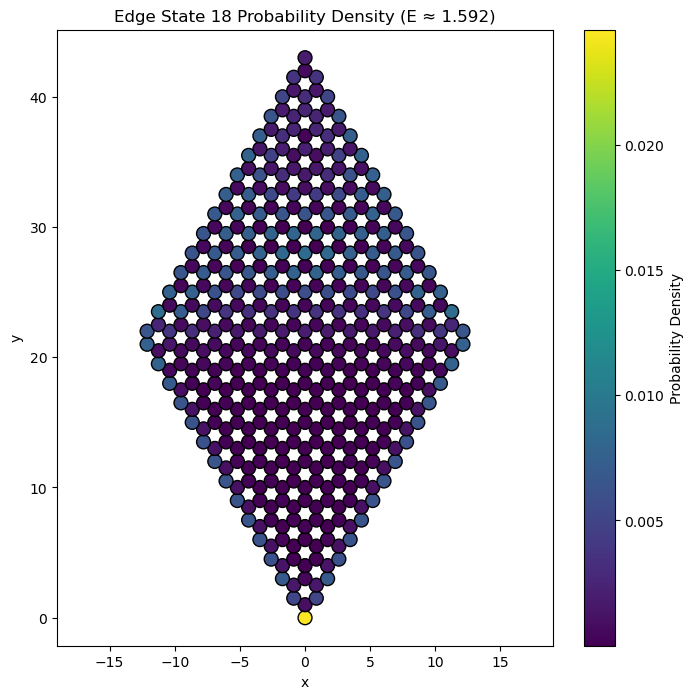

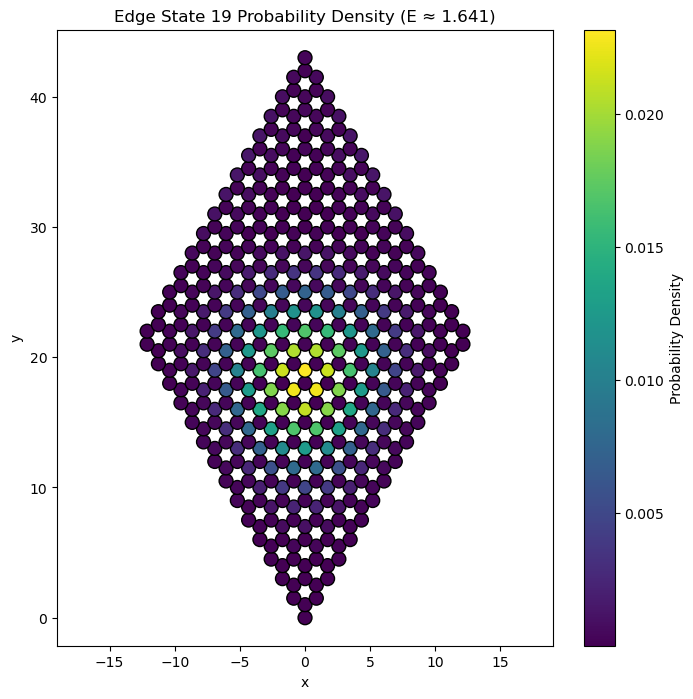

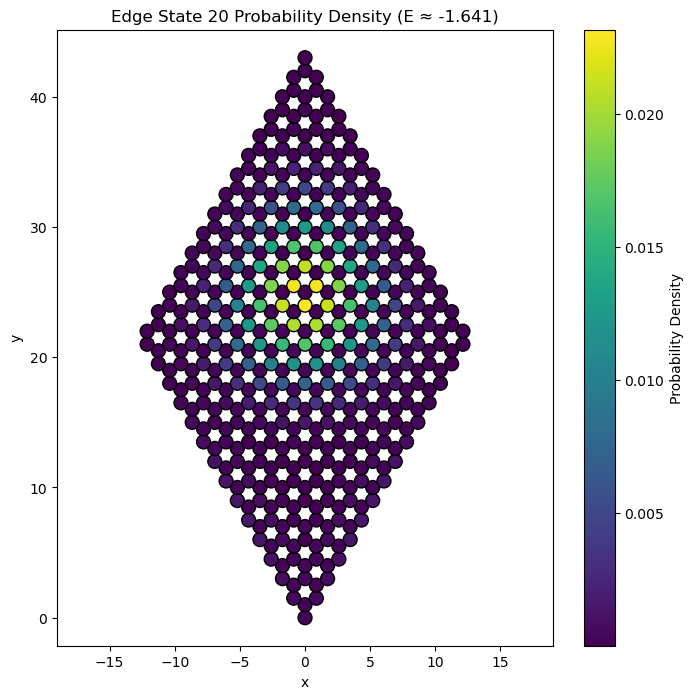

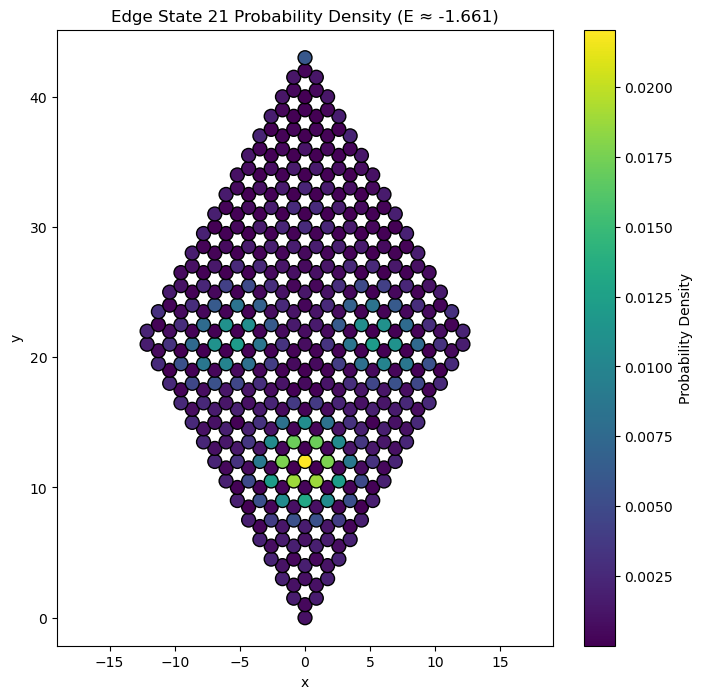

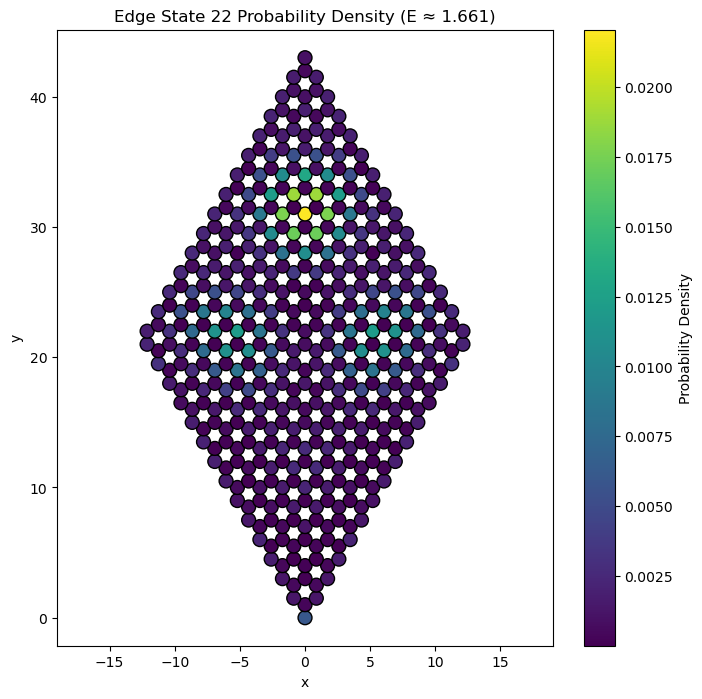

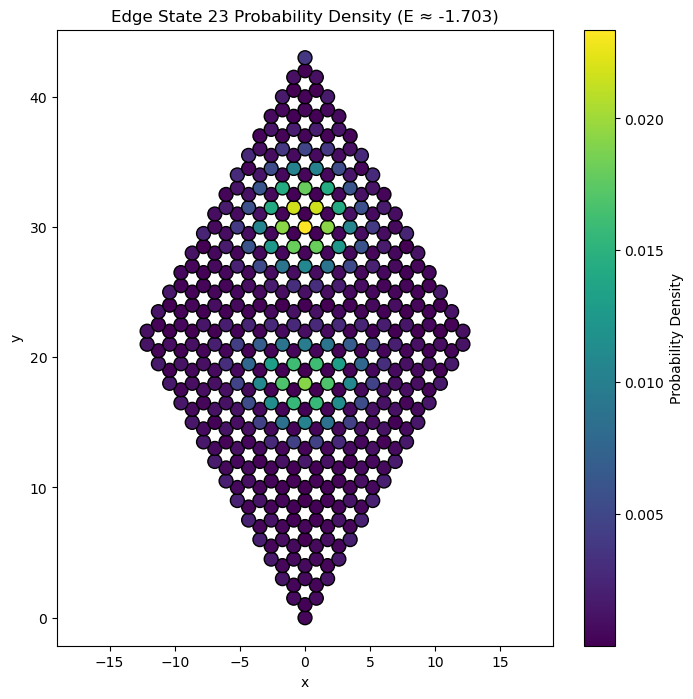

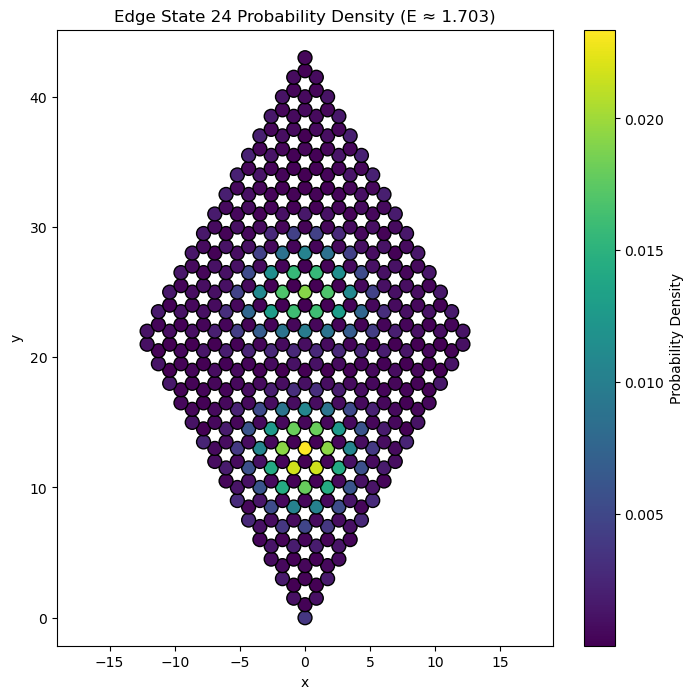

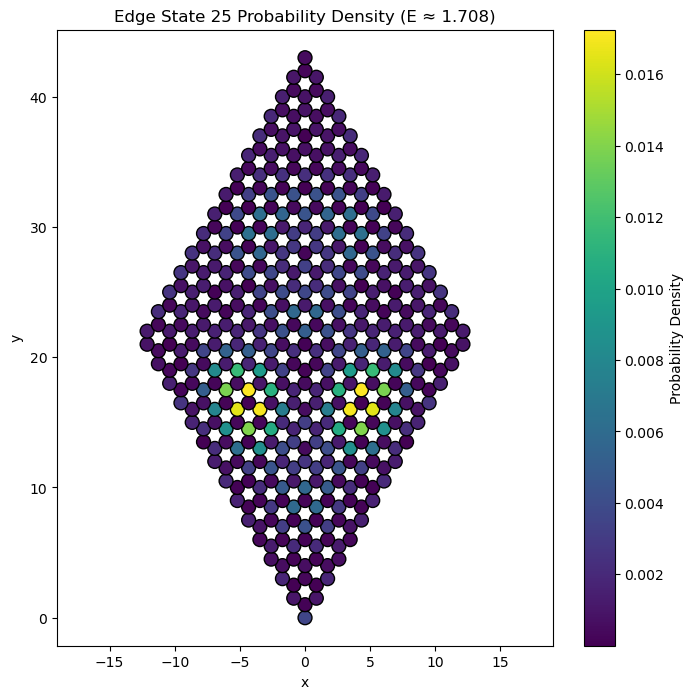

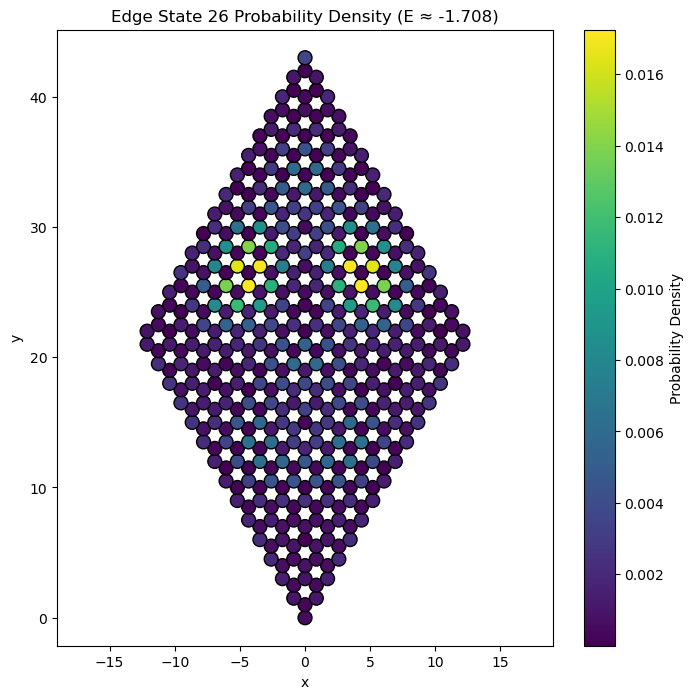

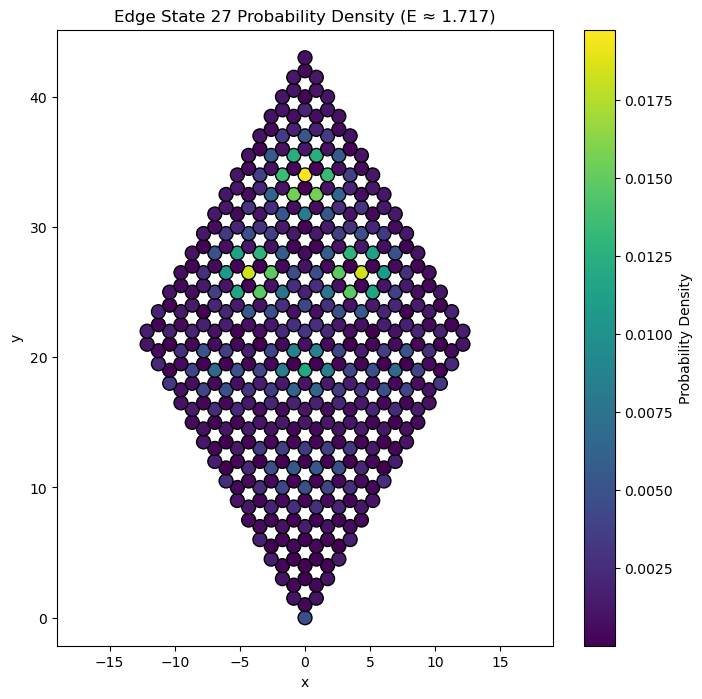

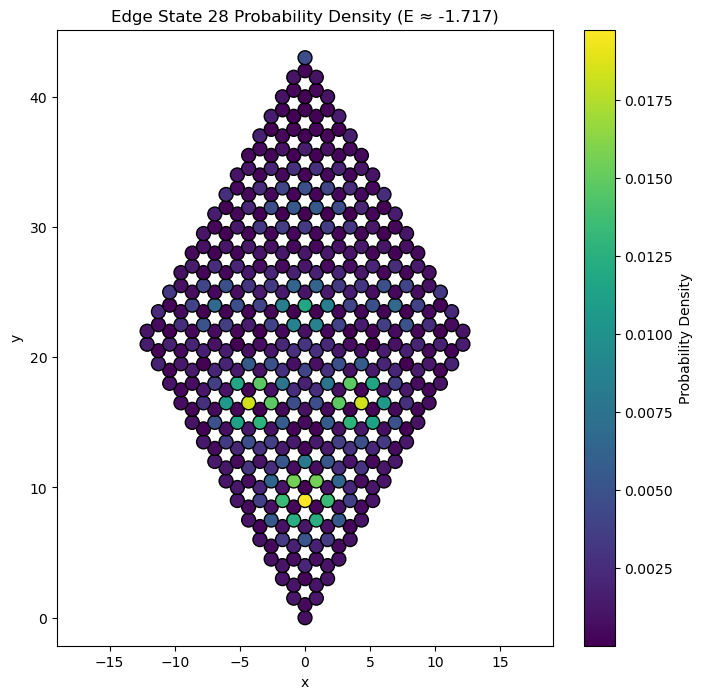

In [87]:
for state_idx in range(nearest_eigenvectors.shape[1]):
    psi = nearest_eigenvectors[:, state_idx]
    prob_density = np.abs(psi)**2  # probability density |ψ|^2
    
    plt.figure(figsize=(8, 8))
    # Create a scatter plot where the color represents the probability density.
    xs = [positions[i][0] for i in range(dim)]
    ys = [positions[i][1] for i in range(dim)]
    sc = plt.scatter(xs, ys, c=prob_density, cmap='viridis', s=100, edgecolors='k')
    plt.colorbar(sc, label='Probability Density')
    plt.title(f'Edge State {state_idx+1} Probability Density (E ≈ {nearest_eigenvalues[state_idx]:.3f})')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.show()
